In [9]:
import xgboost as xgb
import pandas as pd
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from helper_functions.Classification_eval import lift_score, eval_metrics, plot_shap_summary_and_importance

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [15]:
train.head()

,Unnamed: 0,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,txn_hour_18,txn_hour_19,txn_hour_20,txn_hour_21,txn_hour_22,txn_hour_23,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,0,157,5530.25,C657793176,0.0,0.00,M739568006,0.00,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
1,1,260,110352.76,C1412043435,0.0,0.00,C41698878,2574546.99,2684899.76,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1,0,0,0
2,2,44,5406.11,C450614947,81630.0,76223.89,M691104477,0.00,0.00,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0,0,1,0
3,3,350,8221.22,C1796508227,3697.0,0.00,M1692201305,0.00,0.00,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0
4,4,238,7787.64,C381041925,82938.0,75150.36,M382945339,0.00,0.00,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0,0,1,0


In [16]:
all_columns_fit = [col for col in train.columns if col not in ['step', 'isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest', 'Unnamed: 0' ]]
all_columns_fit

['amount',
 'oldbalanceOrig',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'merchOrig',
 'merchDest',
 'merchInvolved',
 'origBalanceCleared',
 'amount_eq_bal',
 'prev_orig_steps_num',
 'prev_orig_avg_amount',
 'prev_orig_fraud_max',
 'prev_orig_txn_hour_avg',
 'prev_orig_merchInvolved_total',
 'prev_orig_merch_orig_sum',
 'prev_orig_merchDest_sum',
 'prev_dest_steps_num',
 'prev_dest_avg_amount',
 'prev_dest_fraud_max',
 'prev_dest_txn_hour_avg',
 'prev_dest_merchInvolved_total',
 'prev_dest_merch_orig_sum',
 'prev_dest_merchDest_sum',
 'log_oldbalanceOrig',
 'log_newbalanceOrig',
 'log_oldbalanceDest',
 'log_newbalanceDest',
 'log_amount',
 'log_prev_orig_avg_amount',
 'log_prev_dest_avg_amount',
 'hour_diff_orig',
 'hour_diff_dest',
 'amt_diff_orig',
 'amt_diff_dest',
 'missingindicator_prev_orig_steps_num',
 'missingindicator_prev_orig_avg_amount',
 'missingindicator_prev_orig_fraud_max',
 'missingindicator_prev_orig_txn_hour_avg',
 'missingindicator_prev_orig_merchInv

In [17]:
xgb_clf = xgb.XGBClassifier(tree_method="hist", random_state =123)

xgb_model = xgb_clf.fit( train[all_columns_fit], train['isFraud'] )

Model metrics Summary: 
%s               precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270891
           1       1.00      1.00      1.00      1633

    accuracy                           1.00   1272524
   macro avg       1.00      1.00      1.00   1272524
weighted avg       1.00      1.00      1.00   1272524

Model Lift Report: 
%s    decile  response_rate   count      lift
0       1       0.012817  127253  9.987706
1       2       0.000000  127244  0.000000
2       3       0.000000  127258  0.000000
3       4       0.000009  109585  0.007111
4       5       0.000000  144871  0.000000
5       6       0.000000  127303  0.000000
6       7       0.000000  127252  0.000000
7       8       0.000008  125391  0.006215
8       9       0.000000  126871  0.000000
9      10       0.000000  129496  0.000000


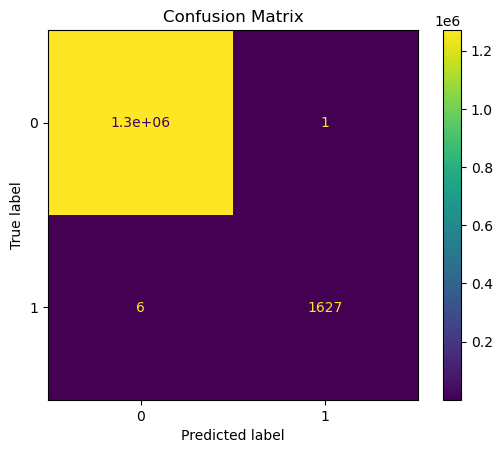

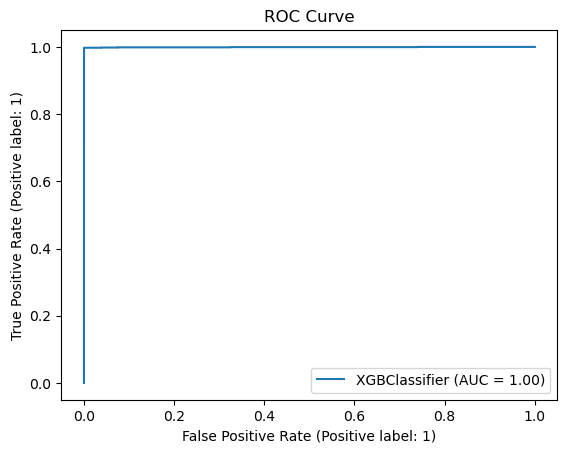

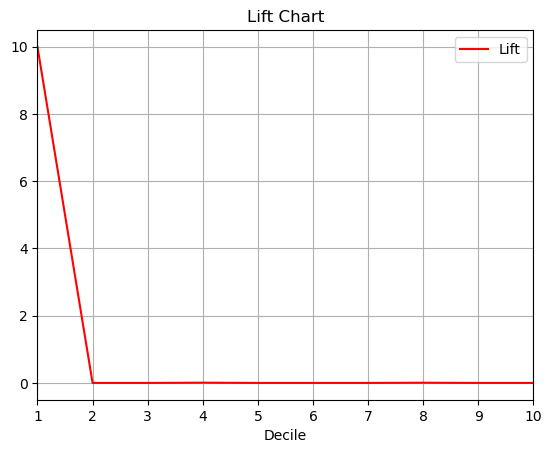

In [18]:
eval_metrics(xgb_model, test[all_columns_fit], test['isFraud'])

[20:35:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


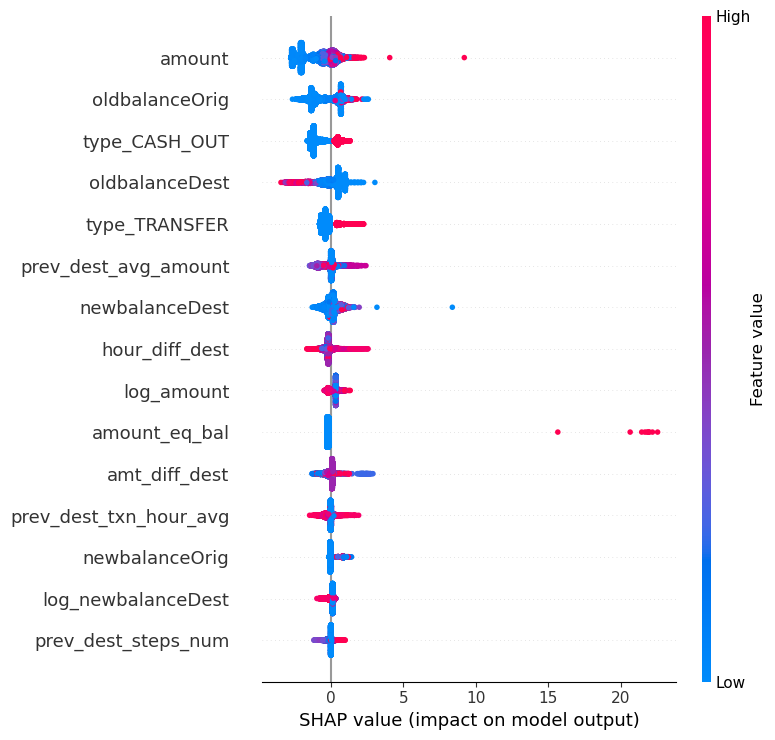

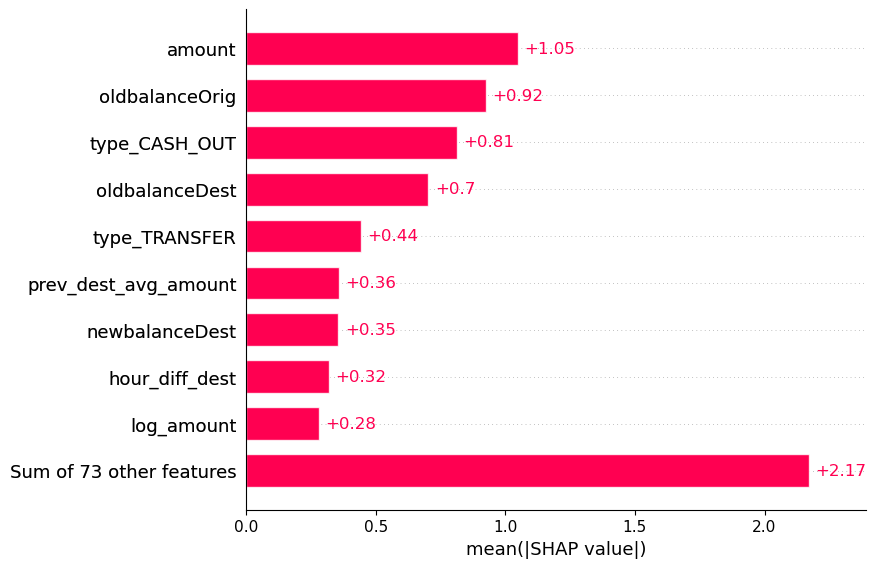

In [24]:
plot_shap_summary_and_importance(xgb_model, test[all_columns_fit],  max_display=15, random_state=123)